# Build images for custom inference for 🤗 HuggingFace models

In order to deploy HuggingFace models in Vertex AI we will need to make use of the Custom Prediction Routines (CPR) which are Docker images built with custom inference code and requirements (among other optional stuff).

These images need to be built for HuggingFace's libraries i.e. `tranformers`, `diffusers` and much more; as there are no official Docker images yet for HuggingFace, while those are available for `sklearn`, `AutoML` and `XGBoost` models.

In this tutorial we will show how to use the Python library `google-cloud-aiplatform` to build and register new CPRs in Google's Container Registry, for its later inference usage within Vertex AI.

## Installation

* `gcloud` CLI needs to be installed and logged in the project that will be used to push the Docker images. See the installation notes at https://cloud.google.com/sdk/docs/install

* `docker` needs to be installed locally, and up and running, since it will be used to build the CPR images before pushing those to the container registry. See the installation notes at https://docs.docker.com/engine/install/

* `google-cloud-aiplatform` Python library is required to programatically build the CPR image and to define the custom prediction code via a custom `Predictor`.

    `pip install google-cloud-aiplatform --upgrade`

## Setup

To successfully run the code below, you will need to be authenticated into your Google Cloud account and the following variable values must be set in advance:

* `REGION` is the region where the resources will be hosted in.
* `PROJECT_ID` is the identifier of the project in Google Cloud.
* `REPOSITORY` is the directory where the Docker images will be uploaded to.
* `IMAGE` is the name of the Docker image (without tag).
* `TAG` is that tag of the Docker image.

In [ ]:
REGION = "europe-west9"
PROJECT_ID = "huggingface-cloud"
REPOSITORY = "custom-inference"
IMAGE = "huggingface-pipeline"
TAG = "py310-cpu-torch-2.2.0-transformers-4.37.2"

---

_**Note**: the following is a CPU-only version for custom inference, to use GPU for inference, the `device_map` should be defined (ideally with `auto` as the value), `accelerate` should be included to `requirements.txt`, and a CUDA image should be used when building the CPR via `build_cpr_model`._

## Custom inference code

In order to successfully run the inference over a HuggingFace model, we will need to define a custom class inheriting from the `Predictor` class from `google-cloud-aiplatform`.

To run the inference we will use the `pipeline` method from 🤗 `transformers`, which will be loaded as part of the `Predictor.load` method, controlled by the environment variable `HF_TASK`; then the `pipeline` will run within the `predict` method and will generate the output as a Python dict.

Alternatively, we could also implement ourselves the code rather than relying on `pipeline` if our model needs to suit specific needs, while the `pipeline` controlled via the `HF_TASK` environment variable gives the image flexibility as we can build one image and make it work for different models and tasks (as long as those don't have extra requirements), and custom images with too specific codes may only perform well under certain scenarios.

In [ ]:
!mkdir huggingface_predictor

_Note that we will use the magic method `%%writefile` to write the Python code of the `HuggingFacePredictor` into the `predictor.py` file, which won't import the code within the Jupyter Notebook, so we will need to load it afterwards using `%load`._

In [ ]:
%%writefile huggingface_predictor/predictor.py
import os
import logging
import tarfile
from typing import Any, Dict

from transformers import pipeline

from google.cloud.aiplatform.prediction.predictor import Predictor
from google.cloud.aiplatform.utils import prediction_utils

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)


class HuggingFacePredictor(Predictor):
    def __init__(self) -> None:
        pass
    
    def load(self, artifacts_uri: str) -> None:
        """Loads the preprocessor and model artifacts."""
        logger.debug(f"Downloading artifacts from {artifacts_uri}")
        prediction_utils.download_model_artifacts(artifacts_uri)
        logger.debug(f"Artifacts successfully downloaded!")
        os.makedirs("./model", exist_ok=True)
        with tarfile.open("model.tar.gz", "r:gz") as tar:
            tar.extractall(path="./model")
        logger.debug(f"HF_TASK value is {os.getenv('HF_TASK')}")
        self._pipeline = pipeline(os.getenv("HF_TASK", None), model="./model")
        logger.debug(f"`pipeline` successfully loaded!")

    def predict(self, instances: Dict[str, Any]) -> Dict[str, Any]:
        return self._pipeline(**instances)

Besides the `Predictor` we can alternatively add a `requirements.txt` file containing the requirements needed to run the code snippet above, which will be installed as part of the Custom Prediction Routine (CPR), that will build a Vertex AI compatible Docker image automatically including both `predictor.py` and `requirements.txt`.

In [ ]:
%%writefile huggingface_predictor/requirements.txt
torch==2.2.0
transformers==4.37.2

## Build Docker image

Before building the image we will need to create the Docker repository in Google Artifact Registry, otherwise it will fail not when building the image but when trying to push it, meaning that we would need to re-run the build, so make sure that the repository exists in advance or create it with `gcloud` as it follows:

In [ ]:
!gcloud artifacts repositories create custom-inference --repository-format=docker --location={REGION}

Once we've ensured that the Docker repository exists and that we've packaged the code into the `huggingface_predictor` directory (containing both `predictor.py` and `requirements.txt`), we will build the Custom Prediction Routine (CPR) which will create and build the Docker image in the Google Container Registry.

In this case we need to define the following args:
* `src_dir` is the path to the local directory including the required files (will be copied into the image)
* `output_image_uri` is the URI where the Docker image will be pushed to in Google Cloud
* `predictor` is the class instance that inherits from the `Predictor` i.e. `HuggingFacePredictor`
* `requirements_path` is the path to the `requirements.txt` file
* `base_image` is the base image that will be defined within the Docker image

_Note that `docker` needs to be installed in advanced and running, since it will be internally used to build the image, and it may take a while._

In [ ]:
import os
from google.cloud.aiplatform.prediction import LocalModel

from huggingface_predictor.predictor import HuggingFacePredictor

local_model = LocalModel.build_cpr_model(
    "huggingface_predictor",
    f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{REPOSITORY}/{IMAGE}:{TAG}",
    predictor=HuggingFacePredictor,
    requirements_path="huggingface_predictor/requirements.txt",
    base_image="--platform=linux/amd64 python:3.10 AS build",
)

## Push Docker image

Once the image has been built, we can push it to the Google Container Registry via the `push_image` method of the `LocalModel`. But before pushing the image we will need to ensure that the container registry is configured via the `gcloud auth configure-docker` command.

In [ ]:
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet

Then we can call the `push_image` method that will internally call `docker push` to the container registry.

In [ ]:
local_model.push_image()

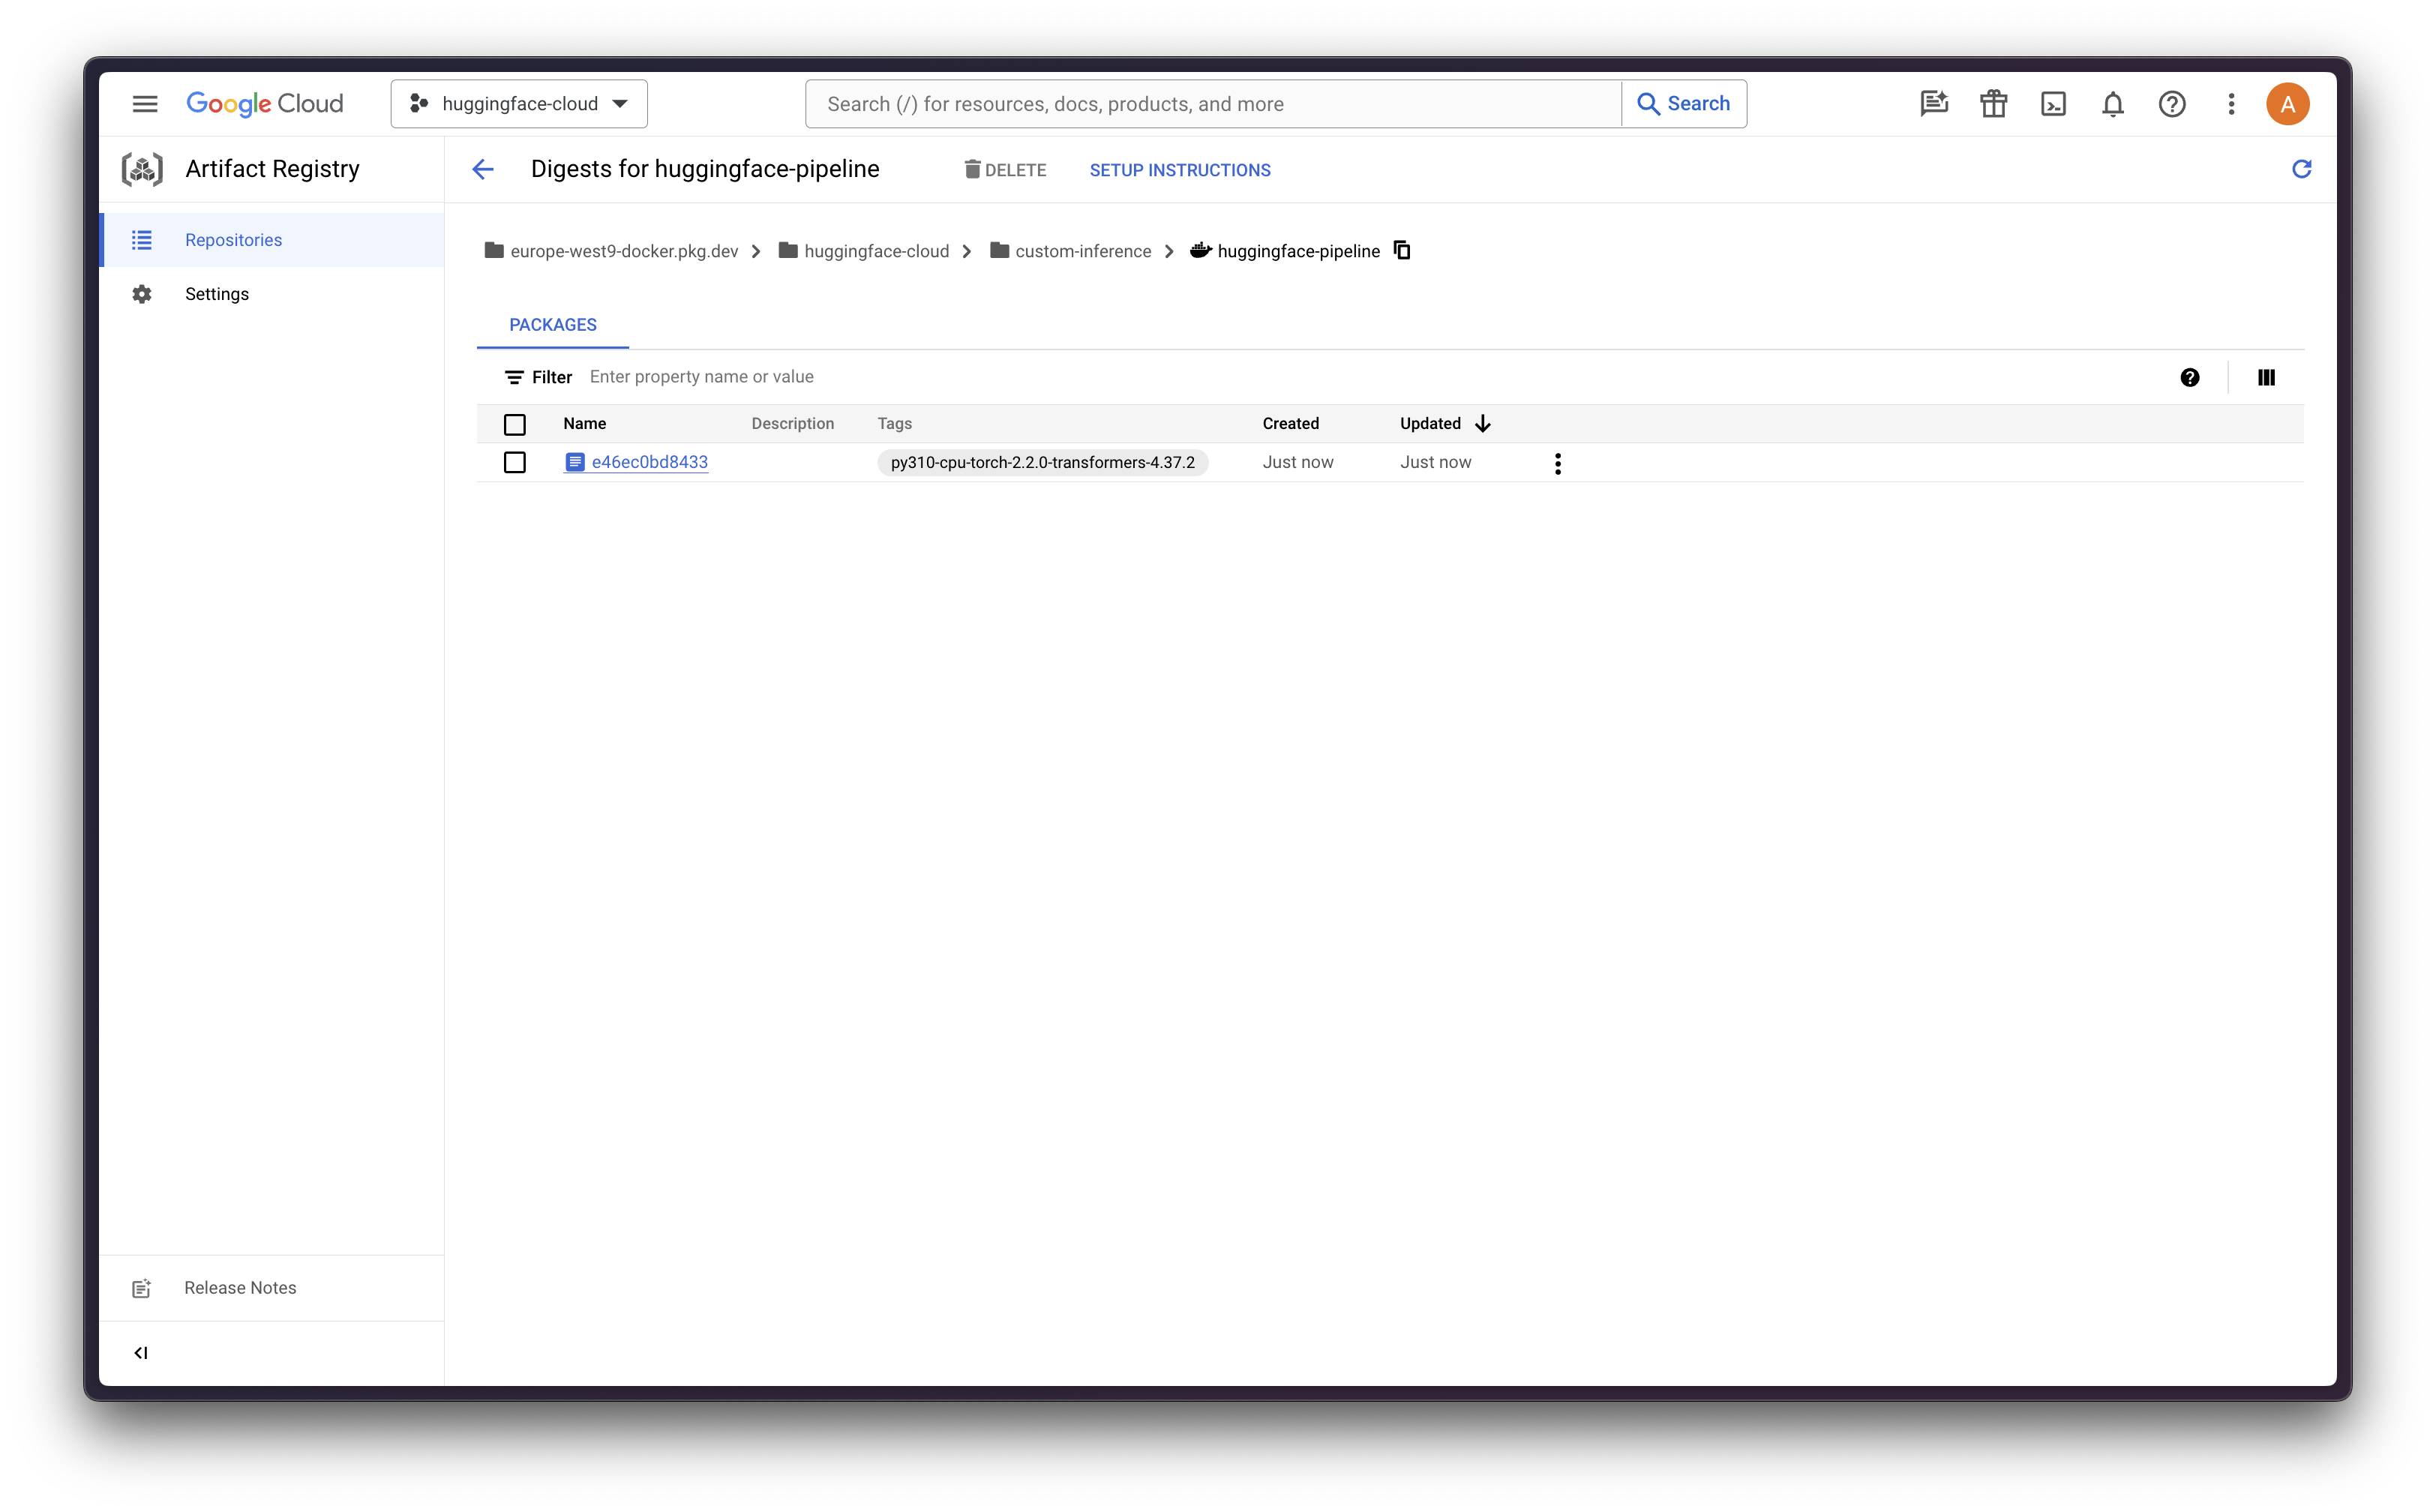